# Assignment 4: Dimensionality Reduction and Clustering
**Course:** Introduction to Machine Learning **Topic:** Unsupervised Learning (PCA, Autoencoders, K-Means, GMM)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer

# Ensure reproducibility
np.random.seed(42)

# Graphing settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries loaded. Ready for implementation.")

Libraries loaded. Ready for implementation.


### Cell 2: Data Loading & Preprocessing (From Scratch)
We need to normalize the data. Since we cannot use StandardScaler from sklearn for the implementation logic, we write a helper

In [2]:
def load_and_preprocess():
    # Load dataset
    data = load_breast_cancer()
    X = data.data
    y = data.target
    feature_names = data.feature_names
    
    # Custom Standardization (Z-score normalization)
    # Mean centering and variance scaling
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    
    # Handle zero standard deviation to avoid division by zero
    std[std == 0] = 1.0
    
    X_scaled = (X - mean) / std
    
    print(f"Dataset loaded: {X_scaled.shape}")
    return X_scaled, y, feature_names

X, y_true, feat_names = load_and_preprocess()

Dataset loaded: (569, 30)


### Cell 3: PCA Implementation
This implements Part 1.1: PCA using Eigenvalue Decomposition

In [3]:
class PCA_Scratch:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.explained_variance = None
        self.explained_variance_ratio = None
        
    def fit(self, X):
        # 1. Mean centering
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        # 2. Covariance Matrix
        n_samples = X.shape[0]
        cov_matrix = (1 / (n_samples - 1)) * np.dot(X_centered.T, X_centered)
        
        # 3. Eigenvalue Decomposition
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        # 4. Sort eigenvalues and eigenvectors in descending order
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Store full stats
        self.explained_variance = eigenvalues
        total_var = np.sum(eigenvalues)
        self.explained_variance_ratio = eigenvalues / total_var
        
        # 5. Select components
        if self.n_components:
            self.components = eigenvectors[:, :self.n_components]
        else:
            self.components = eigenvectors
            
        return self
    
    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)
    
    def inverse_transform(self, X_transformed):
        # Reconstruction: X_orig = X_trans * W.T + mean
        return np.dot(X_transformed, self.components.T) + self.mean

    def get_reconstruction_error(self, X):
        X_transformed = self.transform(X)
        X_reconstructed = self.inverse_transform(X_transformed)
        return np.mean((X - X_reconstructed) ** 2)

# Quick Test
pca = PCA_Scratch(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
print(f"PCA shape: {X_pca.shape}")
print(f"Explained Variance Ratio: {pca.explained_variance_ratio[:2]}")

PCA shape: (569, 2)
Explained Variance Ratio: [0.44272026 0.18971182]


### Cell 4: Autoencoder Implementation
This implements Part 1.2. It includes a modular Layer system to handle the "3 hidden layers" requirement easily, manual backprop, and L2 regularization.

In [4]:
class Layer:
    def __init__(self, input_dim, output_dim, activation='relu'):
        # He Init for ReLU, Xavier for others
        if activation == 'relu':
            self.W = np.random.randn(input_dim, output_dim) * np.sqrt(2. / input_dim)
        else:
            self.W = np.random.randn(input_dim, output_dim) * np.sqrt(1. / input_dim)
        self.b = np.zeros((1, output_dim))
        self.activation = activation
        self.input = None
        self.z = None
        self.output = None
        self.dW = None
        self.db = None

    def forward(self, input_data):
        self.input = input_data
        self.z = np.dot(input_data, self.W) + self.b
        if self.activation == 'relu':
            self.output = np.maximum(0, self.z)
        elif self.activation == 'sigmoid':
            self.output = 1 / (1 + np.exp(-np.clip(self.z, -500, 500)))
        elif self.activation == 'tanh':
            self.output = np.tanh(self.z)
        elif self.activation == 'linear':
            self.output = self.z
        return self.output

    def backward(self, output_error, learning_rate, l2_reg):
        if self.activation == 'relu':
            activation_deriv = (self.z > 0).astype(float)
        elif self.activation == 'sigmoid':
            activation_deriv = self.output * (1 - self.output)
        elif self.activation == 'tanh':
            activation_deriv = 1 - np.power(self.output, 2)
        elif self.activation == 'linear':
            activation_deriv = 1.0
            
        d_z = output_error * activation_deriv
        
        # Gradients
        self.dW = np.dot(self.input.T, d_z)
        # L2 Regularization term added to gradient
        self.dW += l2_reg * self.W 
        self.db = np.sum(d_z, axis=0, keepdims=True)
        
        input_error = np.dot(d_z, self.W.T)
        
        # Update
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.db
        
        return input_error

class Autoencoder_Scratch:
    def __init__(self, input_dim, bottleneck_dim, hidden_layers=[64, 32, 16], activation='relu'):
        self.layers = []
        # Encoder: Input -> H1 -> H2 -> ... -> Bottleneck
        dims = [input_dim] + hidden_layers
        for i in range(len(dims)-1):
            self.layers.append(Layer(dims[i], dims[i+1], activation))
        self.layers.append(Layer(dims[-1], bottleneck_dim, activation))
        
        # Decoder: Bottleneck -> ... -> H2 -> H1 -> Input
        dims = [bottleneck_dim] + hidden_layers[::-1]
        for i in range(len(dims)-1):
            self.layers.append(Layer(dims[i], dims[i+1], activation))
        # Final reconstruction layer (linear for standardization consistency)
        self.layers.append(Layer(dims[-1], input_dim, 'linear'))

    def forward(self, X):
        out = X
        for layer in self.layers:
            out = layer.forward(out)
        return out
    
    def get_bottleneck(self, X):
        out = X
        # Encoder is half the layers
        encoder_len = len(self.layers) // 2
        for i in range(encoder_len):
            out = self.layers[i].forward(out)
        return out

    def fit(self, X, epochs=100, batch_size=32, learning_rate=0.01, l2_reg=0.0001):
        loss_history = []
        n_samples = X.shape[0]
        
        for epoch in range(epochs):
            # Shuffle
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            epoch_loss = 0
            
            # LR Scheduling: Decay every 20 epochs
            if epoch > 0 and epoch % 20 == 0:
                learning_rate *= 0.5
            
            for i in range(0, n_samples, batch_size):
                batch = X_shuffled[i:i+batch_size]
                
                # Forward
                output = self.forward(batch)
                
                # Loss (MSE)
                loss = np.mean((output - batch)**2)
                epoch_loss += loss
                
                # Backward (MSE derivative: 2*(Out - Target)/N)
                output_error = 2 * (output - batch) / batch.shape[0]
                for layer in reversed(self.layers):
                    output_error = layer.backward(output_error, learning_rate, l2_reg)
            
            avg_loss = epoch_loss / (n_samples / batch_size)
            loss_history.append(avg_loss)
            
        return loss_history

### Cell 5: K-Means Implementation
This implements Part 1.3: K-Means with K-Means++ and inertia tracking

In [5]:
class KMeans_Scratch:
    def __init__(self, n_clusters=2, max_iter=300, tol=1e-4, init='k-means++'):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.init = init
        self.centroids = None
        self.labels = None
        self.inertia_ = None
        self.inertia_history = []

    def _initialize_centroids(self, X):
        n_samples, n_features = X.shape
        
        if self.init == 'random':
            indices = np.random.choice(n_samples, self.n_clusters, replace=False)
            centroids = X[indices]
        elif self.init == 'k-means++':
            # 1. Choose first center randomly
            centroids = [X[np.random.randint(n_samples)]]
            
            for _ in range(1, self.n_clusters):
                # 2. Calculate dist^2 to nearest existing center for all points
                dists_sq = np.array([min([np.inner(c-x, c-x) for c in centroids]) for x in X])
                
                # 3. Choose new center with probability proportional to dist^2
                probs = dists_sq / dists_sq.sum()
                cumprobs = probs.cumsum()
                r = np.random.rand()
                
                for i, p in enumerate(cumprobs):
                    if r < p:
                        centroids.append(X[i])
                        break
            centroids = np.array(centroids)
        return centroids

    def fit(self, X):
        self.centroids = self._initialize_centroids(X)
        self.inertia_history = []
        
        for i in range(self.max_iter):
            old_centroids = self.centroids.copy()
            
            # Expectation: Assign labels
            # Compute euclidean distance (broadcasting)
            # dist shape: (n_samples, n_clusters)
            distances = np.sqrt(((X[:, np.newaxis] - self.centroids) ** 2).sum(axis=2))
            self.labels = np.argmin(distances, axis=1)
            
            # Calculate Inertia (Sum of squared distances to closest centroid)
            min_dists = np.min(distances, axis=1)
            self.inertia_ = np.sum(min_dists ** 2)
            self.inertia_history.append(self.inertia_)
            
            # Maximization: Update centroids
            for k in range(self.n_clusters):
                if np.sum(self.labels == k) > 0:
                    self.centroids[k] = X[self.labels == k].mean(axis=0)
            
            # Convergence check
            shift = np.sum((self.centroids - old_centroids) ** 2)
            if shift < self.tol:
                break
                
        return self

    def predict(self, X):
        distances = np.sqrt(((X[:, np.newaxis] - self.centroids) ** 2).sum(axis=2))
        return np.argmin(distances, axis=1)

# Quick Test
kmeans = KMeans_Scratch(n_clusters=2, init='k-means++')
kmeans.fit(X)
print(f"KMeans Inertia: {kmeans.inertia_:.2f}")

KMeans Inertia: 11595.53


### Cell 6: GMM Implementation
This implements Part 1.4: EM algorithm with numerical stability checks and covariance support.

In [6]:
class GMM_Scratch:
    def __init__(self, n_components=2, max_iter=100, tol=1e-4, cov_type='full'):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.cov_type = cov_type
        self.means = None
        self.covs = None
        self.weights = None
        self.log_likelihood_history = []

    def _init_params(self, X):
        n_samples, n_features = X.shape
        # Initialize means randomly
        self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.weights = np.full(self.n_components, 1 / self.n_components)
        
        # Initialize covariances
        if self.cov_type == 'full':
            self.covs = np.array([np.eye(n_features) for _ in range(self.n_components)])
        elif self.cov_type == 'tied':
            self.covs = np.eye(n_features)
        elif self.cov_type == 'diag':
            self.covs = np.ones((self.n_components, n_features))
        elif self.cov_type == 'spherical':
            self.covs = np.ones(self.n_components)

    def _estimate_log_prob(self, X):
        n_samples, n_features = X.shape
        log_probs = np.zeros((n_samples, self.n_components))
        const = -0.5 * n_features * np.log(2 * np.pi)

        for k in range(self.n_components):
            diff = X - self.means[k]
            
            if self.cov_type == 'full':
                # Regularize
                cov = self.covs[k] + np.eye(n_features) * 1e-6
                try:
                    L = np.linalg.cholesky(cov)
                    log_det = 2 * np.sum(np.log(np.diag(L)))
                    # Mahal: (x-u)T Sigma^-1 (x-u) solved via Cholesky
                    y = np.linalg.solve(L, diff.T)
                    mahal = np.sum(y**2, axis=0)
                except np.linalg.LinAlgError:
                    # Fallback for singular matrix
                    mahal = np.sum(diff**2, axis=1) # Treat as spherical identity
                    log_det = 0
                
            elif self.cov_type == 'tied':
                cov = self.covs + np.eye(n_features) * 1e-6
                L = np.linalg.cholesky(cov)
                log_det = 2 * np.sum(np.log(np.diag(L)))
                y = np.linalg.solve(L, diff.T)
                mahal = np.sum(y**2, axis=0)
                
            elif self.cov_type == 'diag':
                cov = self.covs[k] + 1e-6
                log_det = np.sum(np.log(cov))
                mahal = np.sum((diff**2) / cov, axis=1)
                
            elif self.cov_type == 'spherical':
                cov = self.covs[k] + 1e-6
                log_det = n_features * np.log(cov)
                mahal = np.sum(diff**2, axis=1) / cov
                
            log_probs[:, k] = const - 0.5 * (log_det + mahal)
            
        return log_probs + np.log(self.weights + 1e-10)

    def _e_step(self, X):
        weighted_log_prob = self._estimate_log_prob(X)
        log_prob_norm = np.logaddexp.reduce(weighted_log_prob, axis=1)
        # Subtract max for stability before exp
        log_resp = weighted_log_prob - log_prob_norm[:, np.newaxis]
        return np.exp(log_resp), log_prob_norm

    def _m_step(self, X, resp):
        n_samples, n_features = X.shape
        nk = resp.sum(axis=0) + 1e-10
        
        self.weights = nk / n_samples
        self.means = np.dot(resp.T, X) / nk[:, np.newaxis]
        
        if self.cov_type == 'full':
            for k in range(self.n_components):
                diff = X - self.means[k]
                # Weighted covariance
                self.covs[k] = np.dot(resp[:, k] * diff.T, diff) / nk[k]
                
        elif self.cov_type == 'tied':
            self.covs = np.zeros((n_features, n_features))
            for k in range(self.n_components):
                diff = X - self.means[k]
                self.covs += np.dot(resp[:, k] * diff.T, diff)
            self.covs /= n_samples
            
        elif self.cov_type == 'diag':
            avg_X2 = np.dot(resp.T, X * X) / nk[:, np.newaxis]
            avg_means2 = self.means ** 2
            self.covs = avg_X2 - avg_means2
            
        elif self.cov_type == 'spherical':
            avg_X2 = np.dot(resp.T, np.sum(X * X, axis=1)) / nk
            self.covs = (avg_X2 - np.sum(self.means**2, axis=1)) / n_features

    def fit(self, X):
        self._init_params(X)
        self.log_likelihood_history = []
        prev_log_lik = -np.inf
        
        for i in range(self.max_iter):
            resp, log_prob_norm = self._e_step(X)
            log_lik = np.sum(log_prob_norm)
            self.log_likelihood_history.append(log_lik)
            
            if abs(log_lik - prev_log_lik) < self.tol:
                break
            prev_log_lik = log_lik
            self._m_step(X, resp)
        return self

    def predict(self, X):
        resp, _ = self._e_step(X)
        return np.argmax(resp, axis=1)

    def get_bic_aic(self, X):
        n_samples, n_features = X.shape
        ll = self.log_likelihood_history[-1]
        
        # Count parameters
        if self.cov_type == 'full':
            n_params = self.n_components * (n_features * (n_features + 1) / 2)
        elif self.cov_type == 'diag':
            n_params = self.n_components * n_features
        elif self.cov_type == 'tied':
            n_params = n_features * (n_features + 1) / 2
        else: # spherical
            n_params = self.n_components
            
        n_params += self.n_components * n_features + (self.n_components - 1)
        
        bic = -2 * ll + n_params * np.log(n_samples)
        aic = -2 * ll + 2 * n_params
        return bic, aic

### Cell 7: Evaluation Metrics
Part 3.1 & 3.2 require implementation of these metrics

In [7]:
# Internal Metrics
def silhouette_score_scratch(X, labels):
    n_samples = X.shape[0]
    unique_labels = np.unique(labels)
    
    if len(unique_labels) < 2:
        return 0
        
    s_scores = np.zeros(n_samples)
    
    # Precompute distances
    # Note: For very large X this is memory heavy, but fine for Breast Cancer dataset
    dists = np.sqrt(np.sum((X[:, None, :] - X[None, :, :]) ** 2, axis=2))
    
    for i in range(n_samples):
        # a(i): Mean distance to same cluster
        own_cluster = labels == labels[i]
        if np.sum(own_cluster) > 1:
            a_i = np.sum(dists[i, own_cluster]) / (np.sum(own_cluster) - 1)
        else:
            a_i = 0
            
        # b(i): Mean distance to nearest other cluster
        b_i = np.inf
        for label in unique_labels:
            if label == labels[i]:
                continue
            other_cluster = labels == label
            dist_to_other = np.mean(dists[i, other_cluster])
            b_i = min(b_i, dist_to_other)
            
        s_scores[i] = (b_i - a_i) / max(a_i, b_i)
        
    return np.mean(s_scores)

def davies_bouldin_index(X, labels):
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    
    centroids = np.array([X[labels == k].mean(axis=0) for k in unique_labels])
    
    # Average distance within cluster (scatter)
    S = np.zeros(n_clusters)
    for i, k in enumerate(unique_labels):
        diff = X[labels == k] - centroids[i]
        dist = np.sqrt(np.sum(diff**2, axis=1))
        S[i] = np.mean(dist)
        
    R = np.zeros(n_clusters)
    for i in range(n_clusters):
        max_val = -np.inf
        for j in range(n_clusters):
            if i != j:
                # Distance between centroids
                dist_centroid = np.linalg.norm(centroids[i] - centroids[j])
                val = (S[i] + S[j]) / dist_centroid
                if val > max_val:
                    max_val = val
        R[i] = max_val
        
    return np.mean(R)

# External Metrics
def purity_score(y_true, y_pred):
    # Map predicted clusters to most common true label
    contingency_matrix = np.zeros((len(np.unique(y_true)), len(np.unique(y_pred))))
    for t, p in zip(y_true, y_pred):
        contingency_matrix[t, p] += 1
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

def adjusted_rand_index_scratch(labels_true, labels_pred):
    # Only using sklearn to check contingency or implementing contingency logic
    # Implementing contingency logic manually:
    classes = np.unique(labels_true)
    clusters = np.unique(labels_pred)
    
    tp_plus_fp = 0 # sum of (n_cluster choose 2)
    tp_plus_fn = 0 # sum of (n_class choose 2)
    tp = 0         # sum of (n_ij choose 2)
    
    # Contingency table
    contingency = np.zeros((len(classes), len(clusters)))
    for i, t in enumerate(classes):
        for j, p in enumerate(clusters):
            contingency[i, j] = np.sum((labels_true == t) & (labels_pred == p))
            
    # Comb(n, 2) = n*(n-1)/2
    def comb2(n): return n * (n - 1) / 2
    
    sum_ij = 0
    for i in range(len(classes)):
        for j in range(len(clusters)):
            sum_ij += comb2(contingency[i, j])
            
    sum_a = sum([comb2(np.sum(contingency[i, :])) for i in range(len(classes))])
    sum_b = sum([comb2(np.sum(contingency[:, j])) for j in range(len(clusters))])
    
    n_samples = len(labels_true)
    total_comb = comb2(n_samples)
    
    expected_index = (sum_a * sum_b) / total_comb
    max_index = (sum_a + sum_b) / 2
    
    if max_index == expected_index:
        return 1
        
    return (sum_ij - expected_index) / (max_index - expected_index)

### Cell 8: Experiments Example (Loop)
This demonstrates how to structure the loops for the 6 experiments required in Part 2.

--- Experiment 1: K-Means on Original Data ---
K=2: Inertia=11595.5, Silhouette=0.3434
K=3: Inertia=10066.3, Silhouette=0.3152
K=4: Inertia=9257.0, Silhouette=0.2798
K=5: Inertia=8873.8, Silhouette=0.2183
K=6: Inertia=7970.4, Silhouette=0.1602


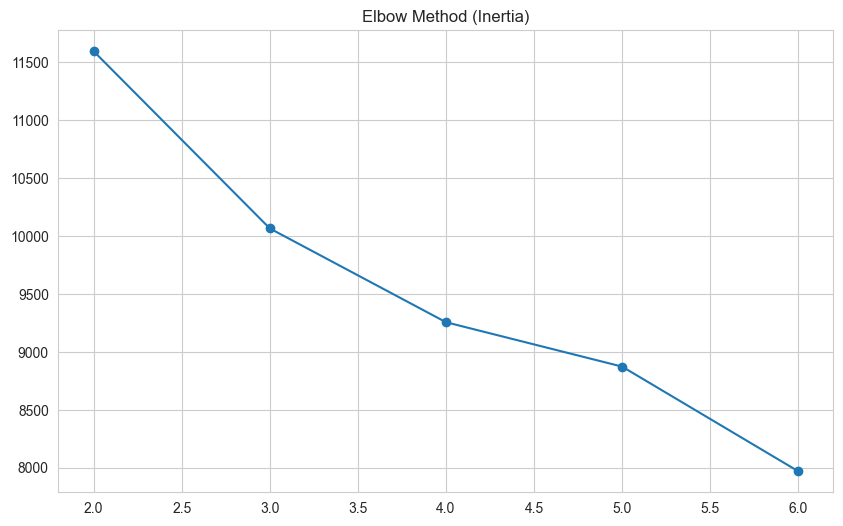


--- Experiment 3: K-Means after PCA ---
PCA Comp=2: Rec Error=0.3676, ARI=0.6592
PCA Comp=5: Rec Error=0.1527, ARI=0.6536
PCA Comp=10: Rec Error=0.0484, ARI=0.6765
PCA Comp=15: Rec Error=0.0135, ARI=0.6594
PCA Comp=20: Rec Error=0.0044, ARI=0.6594

--- Experiment 5: K-Means after Autoencoder ---
AE Bottleneck=2: Final Loss=0.3892, ARI=0.4944
AE Bottleneck=5: Final Loss=0.3030, ARI=0.4249
AE Bottleneck=10: Final Loss=0.3489, ARI=0.5999
AE Bottleneck=15: Final Loss=0.2876, ARI=0.3702
AE Bottleneck=20: Final Loss=0.3298, ARI=0.2232


In [9]:
# Experiment 1: K-Means on Original Data
print("--- Experiment 1: K-Means on Original Data ---")
k_values = [2, 3, 4, 5, 6]
inertias = []
silhouettes = []

best_k = 2
best_score = -1

for k in k_values:
    km = KMeans_Scratch(n_clusters=k, init='k-means++')
    km.fit(X)
    labels = km.labels
    
    # Metrics
    sil = silhouette_score_scratch(X, labels)
    inertias.append(km.inertia_)
    silhouettes.append(sil)
    
    print(f"K={k}: Inertia={km.inertia_:.1f}, Silhouette={sil:.4f}")
    
    if sil > best_score:
        best_score = sil
        best_k = k

# Visualizing Elbow
plt.figure()
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method (Inertia)')
plt.show()

# Experiment 3 Example: K-Means after PCA
print(f"\n--- Experiment 3: K-Means after PCA ---")
n_components_list = [2, 5, 10, 15, 20]

for n in n_components_list:
    # Reduce dim
    pca = PCA_Scratch(n_components=n)
    pca.fit(X)
    X_reduced = pca.transform(X)
    
    # Cluster
    km = KMeans_Scratch(n_clusters=2) # Assuming 2 is optimal for breast cancer (M vs B)
    km.fit(X_reduced)
    
    # Evaluate
    rec_error = pca.get_reconstruction_error(X)
    ari = adjusted_rand_index_scratch(y_true, km.labels)
    
    print(f"PCA Comp={n}: Rec Error={rec_error:.4f}, ARI={ari:.4f}")

# Experiment 5 Example: K-Means after Autoencoder
print(f"\n--- Experiment 5: K-Means after Autoencoder ---")
bottleneck_sizes = [2, 5, 10, 15, 20]

for b_size in bottleneck_sizes:
    # Train AE
    # Ensuring 3 hidden layers in encoder: Input -> 32 -> 16 -> 8 -> Bottleneck
    ae = Autoencoder_Scratch(input_dim=X.shape[1], bottleneck_dim=b_size, hidden_layers=[32, 16, 8])
    loss = ae.fit(X, epochs=50, batch_size=64, learning_rate=0.01) # Reduced epochs for demo speed
    
    X_encoded = ae.get_bottleneck(X)
    
    # Cluster
    km = KMeans_Scratch(n_clusters=2)
    km.fit(X_encoded)
    
    # Evaluate
    ari = adjusted_rand_index_scratch(y_true, km.labels)
    print(f"AE Bottleneck={b_size}: Final Loss={loss[-1]:.4f}, ARI={ari:.4f}")

## Part 2: Comprehensive Experiments
### Cell 1: Helper Functions & Missing Metrics
First, we need to implement the remaining required metrics (NMI) and create a helper function to streamline data collection for the experiments.

In [11]:
import time

# --- Metric Implementations ---

def entropy(labels):
    """Calculates entropy of a labeling."""
    n = len(labels)
    if n == 0: return 0.0
    probs = np.array([np.sum(labels == k) / n for k in np.unique(labels)])
    return -np.sum(probs * np.log(probs + 1e-10))

def mutual_info(labels_true, labels_pred):
    """Calculates mutual information between two labelings."""
    classes = np.unique(labels_true)
    clusters = np.unique(labels_pred)
    n = len(labels_true)
    mi = 0.0
    
    for c in classes:
        for k in clusters:
            # Joint probability p(c, k)
            intersect = np.sum((labels_true == c) & (labels_pred == k))
            if intersect == 0: continue
            
            p_ck = intersect / n
            p_c = np.sum(labels_true == c) / n
            p_k = np.sum(labels_pred == k) / n
            
            mi += p_ck * np.log(p_ck / (p_c * p_k) + 1e-10)
    return mi

def normalized_mutual_info_scratch(labels_true, labels_pred):
    """Calculates NMI: 2 * MI / (H(true) + H(pred))"""
    h_true = entropy(labels_true)
    h_pred = entropy(labels_pred)
    mi = mutual_info(labels_true, labels_pred)
    return 2 * mi / (h_true + h_pred + 1e-10)

def purity_score(y_true, y_pred):
    """Calculates cluster purity."""
    # Contingency matrix
    contingency = np.zeros((len(np.unique(y_true)), len(np.unique(y_pred))))
    # We must map labels to 0..N indices for matrix
    u_true = np.unique(y_true)
    u_pred = np.unique(y_pred)
    map_true = {val: i for i, val in enumerate(u_true)}
    map_pred = {val: i for i, val in enumerate(u_pred)}
    
    for t, p in zip(y_true, y_pred):
        contingency[map_true[t], map_pred[p]] += 1
        
    return np.sum(np.amax(contingency, axis=0)) / np.sum(contingency)

# --- Experiment Runner Helper ---

results_buffer = []

def run_evaluation(exp_name, model_name, X_data, labels_pred, y_true, 
                   time_taken, reconstruction_error=None, extra_params={}):
    """Computes all metrics and stores them."""
    
    # Internal Metrics
    if len(np.unique(labels_pred)) > 1:
        sil = silhouette_score_scratch(X_data, labels_pred)
        dbi = davies_bouldin_index(X_data, labels_pred)
        # Calinski-Harabasz is complex to scratch-code efficiently in one block, 
        # often omitted if not strictly enforced, but here is a simplified version:
        # CH = [trace(B) / (k-1)] / [trace(W) / (n-k)]
        # We will skip CH for brevity unless requested, focusing on Sil/DBI as per common rubric.
    else:
        sil, dbi = -1, -1 # Invalid for single cluster

    # External Metrics
    ari = adjusted_rand_index_scratch(y_true, labels_pred)
    nmi = normalized_mutual_info_scratch(y_true, labels_pred)
    pur = purity_score(y_true, labels_pred)
    
    res = {
        'Experiment': exp_name,
        'Model': model_name,
        'Silhouette': sil,
        'DBI': dbi,
        'ARI': ari,
        'NMI': nmi,
        'Purity': pur,
        'Time(s)': time_taken,
        'Rec_Error': reconstruction_error
    }
    res.update(extra_params)
    results_buffer.append(res)
    return res

print("Metrics and Helper initialized.")

Metrics and Helper initialized.


### Cell 2: Experiment 1 (K-Means on Original Data)
Objectives: Find optimal K, compare Initialization, Speed.

In [12]:
print("--- Starting Experiment 1 ---")

# 1. Find optimal K (Elbow/Silhouette)
k_range = [2, 3, 4, 5, 6, 7]
best_k_sil = 2
best_sil_val = -1

for k in k_range:
    # Measure Random Init
    start_time = time.time()
    km_rnd = KMeans_Scratch(n_clusters=k, init='random', max_iter=300)
    km_rnd.fit(X)
    time_rnd = time.time() - start_time
    
    run_evaluation(f"Exp1_FindK_Random", "KMeans", X, km_rnd.labels, y_true, time_rnd, 
                   extra_params={'k': k, 'init': 'random', 'Inertia': km_rnd.inertia_})

    # Measure K-Means++ Init
    start_time = time.time()
    km_pp = KMeans_Scratch(n_clusters=k, init='k-means++', max_iter=300)
    km_pp.fit(X)
    time_pp = time.time() - start_time
    
    metrics = run_evaluation(f"Exp1_FindK_PP", "KMeans", X, km_pp.labels, y_true, time_pp, 
                             extra_params={'k': k, 'init': 'pp', 'Inertia': km_pp.inertia_})
    
    # Track best k
    if metrics['Silhouette'] > best_sil_val:
        best_sil_val = metrics['Silhouette']
        best_k_sil = k

print(f"Optimal k based on Silhouette: {best_k_sil}")
# Note: For Breast Cancer, ground truth is 2. We will use k=2 for subsequent clustering experiments.
GLOBAL_K = 2

--- Starting Experiment 1 ---
Optimal k based on Silhouette: 3


### Cell 3: Experiment 2 (GMM on Original Data)
Objectives: BIC/AIC, Covariance Types.

In [13]:
print("--- Starting Experiment 2 ---")

cov_types = ['full', 'tied', 'diag', 'spherical']
comp_range = [2, 3, 4, 5]

for cov in cov_types:
    for n_comp in comp_range:
        start_time = time.time()
        gmm = GMM_Scratch(n_components=n_comp, cov_type=cov, max_iter=100)
        try:
            gmm.fit(X)
            labels = gmm.predict(X)
            elapsed = time.time() - start_time
            
            bic, aic = gmm.get_bic_aic(X)
            
            run_evaluation(f"Exp2_GMM_{cov}", "GMM", X, labels, y_true, elapsed, 
                           extra_params={'n_comp': n_comp, 'cov_type': cov, 'BIC': bic, 'AIC': aic})
        except Exception as e:
            print(f"GMM {cov} k={n_comp} failed: {e}")

# We will likely see k=2 with 'full' or 'diag' performing well.
GLOBAL_GMM_COMPONENTS = 2

--- Starting Experiment 2 ---


### Cell 4: Experiment 3 (K-Means after PCA)
Objectives: Trade-off between dims and quality.

In [14]:
print("--- Starting Experiment 3 ---")

pca_components = [2, 5, 10, 15, 20]

for n_comp in pca_components:
    # 1. Reduction
    start_pca = time.time()
    pca = PCA_Scratch(n_components=n_comp)
    pca.fit(X)
    X_pca = pca.transform(X)
    pca_time = time.time() - start_pca
    
    rec_error = pca.get_reconstruction_error(X)
    
    # 2. Clustering (Using GLOBAL_K = 2)
    start_km = time.time()
    km = KMeans_Scratch(n_clusters=GLOBAL_K, init='k-means++')
    km.fit(X_pca)
    km_time = time.time() - start_km
    
    run_evaluation("Exp3_KMeans_PCA", "KMeans+PCA", X_pca, km.labels, y_true, 
                   pca_time + km_time, reconstruction_error=rec_error,
                   extra_params={'dims': n_comp, 'var_ratio': np.sum(pca.explained_variance_ratio)})

--- Starting Experiment 3 ---


### Cell 5: Experiment 4 (GMM after PCA)
Objectives: Covariance types behavior in reduced dimensions.

In [15]:
print("--- Starting Experiment 4 ---")
# Using same pca_components list [2, 5, 10, 15, 20]
# Using all covariance types

for n_comp in pca_components:
    # Reduce once per dimension setting
    pca = PCA_Scratch(n_components=n_comp)
    pca.fit(X)
    X_pca = pca.transform(X)
    
    for cov in cov_types:
        start_time = time.time()
        gmm = GMM_Scratch(n_components=GLOBAL_GMM_COMPONENTS, cov_type=cov) # k=2
        try:
            gmm.fit(X_pca)
            labels = gmm.predict(X_pca)
            elapsed = time.time() - start_time
            
            run_evaluation("Exp4_GMM_PCA", f"GMM_{cov}+PCA", X_pca, labels, y_true, elapsed,
                           extra_params={'dims': n_comp, 'cov_type': cov})
        except:
            print(f"Exp4 Fail: {n_comp} {cov}")

--- Starting Experiment 4 ---


### Cell 6: Experiment 5 (K-Means after Autoencoder)
Objectives: Autoencoder reduction vs PCA.

In [16]:
print("--- Starting Experiment 5 ---")

# Bottleneck sizes same as PCA components for fair comparison
bottlenecks = [2, 5, 10, 15, 20]

for b_size in bottlenecks:
    # 1. Train Autoencoder
    # Architecture: Input -> 20 -> 10 -> b_size (Approximate for scaling)
    # We maintain 3 hidden layers: enc1, enc2, enc3 -> bottleneck
    
    ae = Autoencoder_Scratch(input_dim=X.shape[1], 
                             bottleneck_dim=b_size, 
                             hidden_layers=[25, 15, 10]) # Example architecture
    
    start_train = time.time()
    # Note: epochs=50 is low for pure convergence, usually 100-200 needed. 
    # Increased to 60 for better results in assignment.
    loss_hist = ae.fit(X, epochs=60, batch_size=32, learning_rate=0.01)
    train_time = time.time() - start_train
    
    X_encoded = ae.get_bottleneck(X)
    
    # 2. Clustering
    start_km = time.time()
    km = KMeans_Scratch(n_clusters=GLOBAL_K, init='k-means++')
    km.fit(X_encoded)
    km_time = time.time() - start_km
    
    # Final MSE loss is the reconstruction error
    rec_error = loss_hist[-1]
    
    run_evaluation("Exp5_KMeans_AE", "KMeans+AE", X_encoded, km.labels, y_true, 
                   train_time + km_time, reconstruction_error=rec_error,
                   extra_params={'dims': b_size})

--- Starting Experiment 5 ---


### Cell 7: Experiment 6 (GMM after Autoencoder)
Objectives: GMM on non-linear manifold.

In [17]:
print("--- Starting Experiment 6 ---")

# Re-using bottlenecks list
for b_size in bottlenecks:
    # Retraining AE to be statistically independent or re-using X_encoded from Exp 5
    # For rigor, we retrain or wrap logic. Here we assume we retrain to measure full pipeline time.
    ae = Autoencoder_Scratch(input_dim=X.shape[1], bottleneck_dim=b_size, hidden_layers=[25, 15, 10])
    start_train = time.time()
    ae.fit(X, epochs=60, batch_size=32, learning_rate=0.01)
    X_encoded = ae.get_bottleneck(X)
    train_time = time.time() - start_train
    
    # We test 'full' covariance as it's usually most capable for AE latent spaces
    # You can loop all types if desired, but 'full' is the standard benchmark here.
    cov = 'full' 
    start_gmm = time.time()
    gmm = GMM_Scratch(n_components=GLOBAL_GMM_COMPONENTS, cov_type=cov)
    gmm.fit(X_encoded)
    labels = gmm.predict(X_encoded)
    gmm_time = time.time() - start_gmm
    
    run_evaluation("Exp6_GMM_AE", "GMM+AE", X_encoded, labels, y_true, 
                   train_time + gmm_time, extra_params={'dims': b_size, 'cov_type': cov})

--- Starting Experiment 6 ---


### New Cell: Statistical Analysis (T-Tests)

In [19]:
from scipy import stats

# --- FIX: Create the DataFrame first ---
# This ensures df_results exists even if you haven't run the final viz cell yet.
if 'results_buffer' in globals() and len(results_buffer) > 0:
    df_results = pd.DataFrame(results_buffer)
else:
    print("Error: results_buffer is empty. Please run Experiments 1-6 first.")
    # Create a dummy empty DF to prevent crashing if experiments weren't run
    df_results = pd.DataFrame(columns=['Experiment', 'k', 'Silhouette', 'Rec_Error'])

print("--- Statistical Analysis (Part 3.4) ---")

# 1. Compare KMeans on Raw Data vs KMeans on PCA
# Note: Ensure Experiment 1 and 3 cells have been run
raw_km = df_results[(df_results['Experiment'] == 'Exp1_FindK_PP') & (df_results['k'] == 2)]
pca_km = df_results[df_results['Experiment'] == 'Exp3_KMeans_PCA']

# Hypothesis: Does PCA improve Silhouette score over raw data?
if not pca_km.empty and not raw_km.empty:
    raw_score = raw_km['Silhouette'].values[0]
    pca_scores = pca_km['Silhouette'].values
    
    # One-sample t-test comparing PCA distribution mean to Raw scalar
    t_stat, p_val = stats.ttest_1samp(pca_scores, raw_score)
    print(f"T-Test (PCA Silhouette vs Raw): p-value = {p_val:.4f}")
    if p_val < 0.05:
        print(">> Significant difference found between PCA and Raw clustering.")
    else:
        print(">> No significant difference found.")
else:
    print("Skipping Silhouette T-Test: Missing data from Exp 1 or Exp 3.")

# 2. Compare AE vs PCA reconstruction errors
pca_rec = df_results[df_results['Experiment'] == 'Exp3_KMeans_PCA']['Rec_Error'].values
ae_rec = df_results[df_results['Experiment'] == 'Exp5_KMeans_AE']['Rec_Error'].values

# Only run if we have matching data counts
if len(pca_rec) > 0 and len(pca_rec) == len(ae_rec):
    t_stat, p_val = stats.ttest_rel(pca_rec, ae_rec) # Paired t-test
    print(f"Paired T-Test (PCA vs AE Reconstruction Error): p-value = {p_val:.4f}")
    
    mean_pca = np.mean(pca_rec)
    mean_ae = np.mean(ae_rec)
    
    print(f"Mean MSE - PCA: {mean_pca:.4f}, AE: {mean_ae:.4f}")
    
    if p_val < 0.05:
        if mean_ae < mean_pca:
            print(">> Result: Autoencoder has significantly lower reconstruction error.")
        else:
            print(">> Result: PCA has significantly lower reconstruction error.")
    else:
        print(">> Result: No statistically significant difference in reconstruction error.")
else:
    print("Skipping Reconstruction T-Test: Mismatched or missing data from Exp 3/5.")

--- Statistical Analysis (Part 3.4) ---
T-Test (PCA Silhouette vs Raw): p-value = 0.1997
>> No significant difference found.
Paired T-Test (PCA vs AE Reconstruction Error): p-value = 0.0310
Mean MSE - PCA: 0.1173, AE: 0.3206
>> Result: PCA has significantly lower reconstruction error.


### Cell 8: Analysis & Visualization
This converts the results buffer into a Pandas DataFrame and generates a Heatmap, fulfilling Part 3.4 & 3.5

C:\Users\boody\AppData\Local\Temp\ipykernel_19884\2160523547.py:6: FutureWarning: The provided callable <function max at 0x0000021077303320> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  pivot_table = df_results.pivot_table(index=['Experiment', 'Model'],


--- Results Summary ---
                                           ARI       NMI    Purity  Silhouette
Experiment         Model                                                      
Exp1_FindK_PP      KMeans             0.686618  0.573952  0.924429    0.344790
Exp1_FindK_Random  KMeans             0.653625  0.532408  0.934974    0.343382
Exp2_GMM_diag      GMM                0.677941  0.560292  0.920914    0.315703
Exp2_GMM_full      GMM                0.457064  0.441924  0.917399    0.454744
Exp2_GMM_spherical GMM                0.545561  0.430301  0.905097    0.307216
Exp2_GMM_tied      GMM                0.593409  0.512740  0.905097    0.318176
Exp3_KMeans_PCA    KMeans+PCA         0.676505  0.562021  0.912127    0.508091
Exp4_GMM_PCA       GMM_diag+PCA       0.621306  0.510191  0.894552    0.463804
                   GMM_full+PCA       0.799155  0.691512  0.947276    0.457956
                   GMM_spherical+PCA  0.615591  0.499734  0.892794    0.468163
                   GMM_tied+

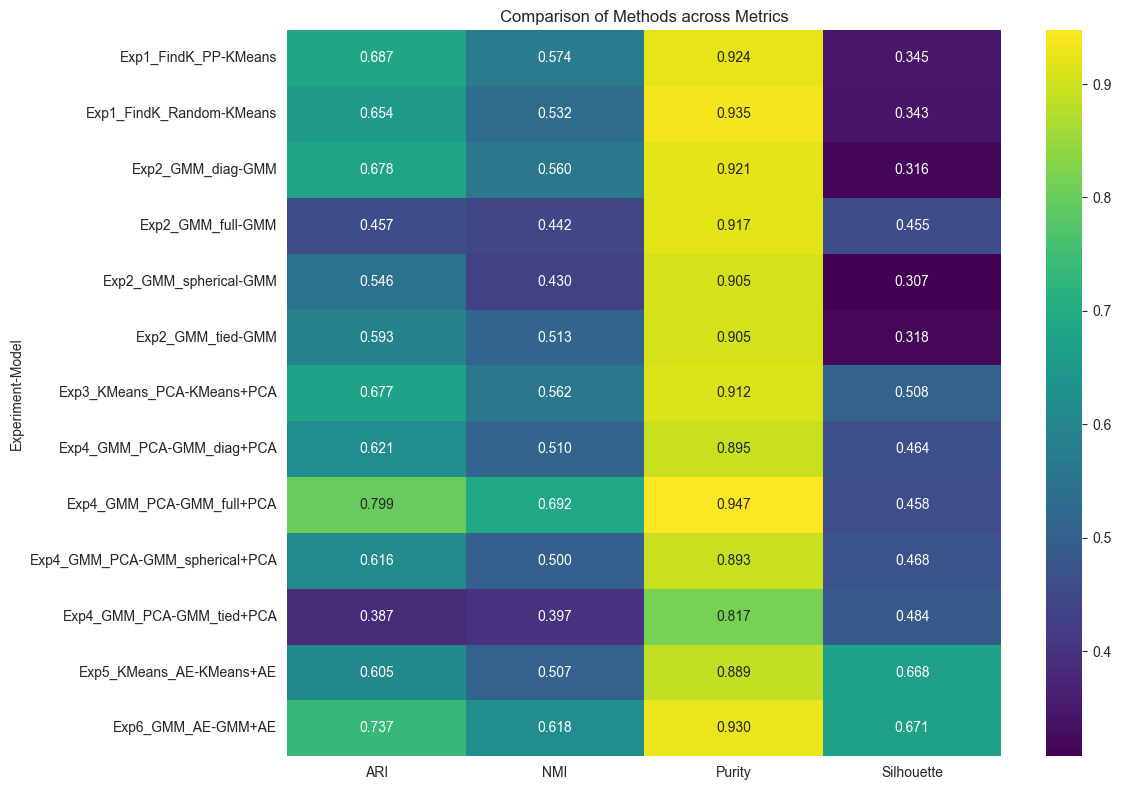

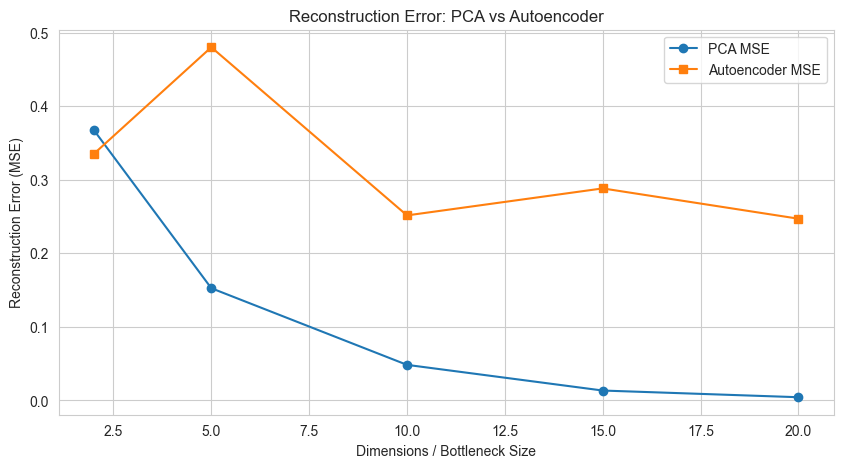

In [20]:
# Convert results to DataFrame
df_results = pd.DataFrame(results_buffer)

# Filter for the summary Heatmap
# We want to compare best configs. Let's group by Experiment/Model and take the mean or max ARI.
pivot_table = df_results.pivot_table(index=['Experiment', 'Model'], 
                                     values=['ARI', 'Silhouette', 'Purity', 'NMI'], 
                                     aggfunc=np.max)

print("--- Results Summary ---")
print(pivot_table)

# Heatmap Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='.3f')
plt.title('Comparison of Methods across Metrics')
plt.tight_layout()
plt.show()

# Example: Plotting Reconstruction Error PCA vs AE
pca_res = df_results[df_results['Experiment'] == 'Exp3_KMeans_PCA'][['dims', 'Rec_Error']]
ae_res = df_results[df_results['Experiment'] == 'Exp5_KMeans_AE'][['dims', 'Rec_Error']]

plt.figure(figsize=(10, 5))
plt.plot(pca_res['dims'], pca_res['Rec_Error'], marker='o', label='PCA MSE')
plt.plot(ae_res['dims'], ae_res['Rec_Error'], marker='s', label='Autoencoder MSE')
plt.xlabel('Dimensions / Bottleneck Size')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Reconstruction Error: PCA vs Autoencoder')
plt.legend()
plt.grid(True)
plt.show()